# Health State Analysis Pipeline

In [9]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

## 1. Health State Duration Analysis

In [10]:
def analyze_health_state_durations(df):
    """Analyze durations of different health states in the dataset."""
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Convert the 'date' column to datetime type
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort the data by cow and date
    df = df.sort_values(by=['cow', 'date'])
    
    def get_health_state_durations(df, health_state_column):
        durations = []
        for cow_id, group in df.groupby('cow'):
            group = group.sort_values('date').reset_index(drop=True)
            current_state = False
            start_date = None
            prev_date = None

            for i, row in group.iterrows():
                if row[health_state_column] == 1:
                    if not current_state:
                        current_state = True
                        start_date = row['date']
                    elif prev_date is not None and (row['date'] - prev_date).days > 1:
                        end_date = prev_date
                        duration = (end_date - start_date).days + 1
                        durations.append({
                            'cow': cow_id,
                            'health_state': health_state_column,
                            'start_date': start_date,
                            'end_date': end_date,
                            'duration_days': duration
                        })
                        start_date = row['date']
                else:
                    if current_state:
                        end_date = prev_date if prev_date is not None else row['date']
                        duration = (end_date - start_date).days + 1
                        durations.append({
                            'cow': cow_id,
                            'health_state': health_state_column,
                            'start_date': start_date,
                            'end_date': end_date,
                            'duration_days': duration
                        })
                        current_state = False
                        start_date = None
                prev_date = row['date']

            if current_state:
                end_date = prev_date
                duration = (end_date - start_date).days + 1
                durations.append({
                    'cow': cow_id,
                    'health_state': health_state_column,
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_days': duration
                })
        return pd.DataFrame(durations)

    health_states = [
        'oestrus', 'lameness', 'mastitis',  'other_disease', 'accidents', 'disturbance',
        'mixing', 'management_changes'
    ]
    
    state_durations = {}
    durations_min_max = {}
    
    for state in health_states:
        durations_df = get_health_state_durations(df, state)
        state_durations[state] = durations_df

        if not durations_df.empty:
            min_duration = durations_df['duration_days'].min()
            max_duration = durations_df['duration_days'].max()
            durations_min_max[state] = {'min_days': min_duration, 'max_days': max_duration}
        else:
            durations_min_max[state] = {'min_days': None, 'max_days': None}
    
    # Display results
    for state, durations in durations_min_max.items():
        min_days = durations['min_days']
        max_days = durations['max_days']

        if min_days is None or max_days is None:
            print(f"No data available for \"{state}\".")
        elif min_days == max_days:
            print(f"{state.capitalize()} lasts {min_days} day{'s' if min_days > 1 else ''}.")
        else:
            print(f"{state.capitalize()} lasts between {min_days} and {max_days} days.")
    
    return state_durations, durations_min_max

## 2. Label Spreading

In [11]:
def spread_labels(df, spread_rules=None):
    """Spread labels to neighboring days based on defined rules."""
    if spread_rules is None:
        spread_rules = {
            'oestrus': {'before': 1, 'after': 1},
            # 'calving': {'before': 2, 'after': 1},
            'lameness': {'before': 2, 'after': 1},
            'mastitis': {'before': 2, 'after': 1},
            # 'LPS': {'before': 2, 'after': 1},
            # 'acidosis': {'before': 2, 'after': 1},
            'other_disease': {'before': 2, 'after': 1},
            'accidents': {'before': 2, 'after': 1},
            'disturbance': {'before': 0, 'after': 0},
            'mixing': {'before': 0, 'after': 0},
            'management_changes': {'before': 0, 'after': 0},
        }
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Identify event columns dynamically
    non_event_cols = ['cow', 'date', 'hour', 'in_alleys', 'rest', 'eat', 'activity_level', 'ok']
    event_cols = [col for col in df.columns if col not in non_event_cols]
    
    # Aggregate daily events
    daily = df.groupby(['cow', 'date'])[event_cols].max().reset_index()
    daily['date'] = pd.to_datetime(daily['date'])
    
    # Create full cow x day table
    all_dates = pd.date_range(daily['date'].min() - timedelta(days=7), 
                             daily['date'].max() + timedelta(days=7))
    cows = daily['cow'].unique()
    full_daily = pd.MultiIndex.from_product([cows, all_dates], names=['cow', 'date']).to_frame(index=False)
    
    # Merge and fill missing
    full_daily = full_daily.merge(daily, on=['cow', 'date'], how='left')
    full_daily[event_cols] = full_daily[event_cols].fillna(0)
    
    # Add LABEL and default OK
    full_daily['label'] = 'control'
    full_daily['ok'] = 1
    
    # Spread labels according to rules
    for cond in event_cols:
        if cond not in spread_rules:
            continue
        sub = full_daily[full_daily[cond] == 1][['cow', 'date']].sort_values(['cow', 'date'])
        for cow_id in sub['cow'].unique():
            cow_days = sub[sub['cow'] == cow_id]['date'].sort_values()
            episode = []
            prev_day = None
            for day in cow_days:
                if prev_day is None or (day - prev_day).days > 1:
                    if episode:
                        min_day = min(episode)
                        max_day = max(episode)
                        spread = spread_rules[cond]
                        spread_days = pd.date_range(min_day - timedelta(days=spread['before']), 
                                               max_day + timedelta(days=spread['after']))
                        mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
                        full_daily.loc[mask, cond] = 1
                        full_daily.loc[mask & (full_daily['label'] == 'control'), 'label'] = cond
                        full_daily.loc[mask, 'ok'] = 0
                    episode = [day]
                else:
                    episode.append(day)
                prev_day = day
            if episode:
                min_day = min(episode)
                max_day = max(episode)
                spread = spread_rules[cond]
                spread_days = pd.date_range(min_day - timedelta(days=spread['before']), 
                                       max_day + timedelta(days=spread['after']))
                mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
                full_daily.loc[mask, cond] = 1
                full_daily.loc[mask & (full_daily['label'] == 'control'), 'label'] = cond
                full_daily.loc[mask, 'ok'] = 0
    
    # Prepare df before merging
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(columns=event_cols + ['ok'], errors='ignore')
    
    # Merge cleanly
    final = df.merge(full_daily[['cow', 'date', 'label'] + event_cols + ['ok']], 
                    on=['cow', 'date'], how='left')
    
    # If a day was labeled with an event, update hourly events if missing
    for cond in event_cols:
        final.loc[(final['label'] == cond) & (final[cond] == 0), cond] = 1
    
    return final

## 3. KNN Imputation

In [12]:
def impute_with_knn(df, useful_classes=None, removed_classes=None):
    """Impute missing labels using K-Nearest Neighbors."""
    if useful_classes is None:
        useful_classes = ['mastitis', 'lameness', 'oestrus', 'other_disease', 'ok']
    if removed_classes is None:
        removed_classes = ['management_changes', 'mixing', 'disturbance', 'accidents']
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Tag samples based on unwanted classes
    df['needs_replacement'] = df[removed_classes].max(axis=1)
    
    # Create the physiological label
    def get_physio_label(row):
        for cond in useful_classes:
            if row[cond] == 1:
                return cond
        return None
    
    df['physio_label'] = df.apply(get_physio_label, axis=1)
    
    # Split into clean vs. to-replace
    to_replace = df[(df['needs_replacement'] == 1) & (df['physio_label'].isnull())].copy()
    clean_physio = df[(df['needs_replacement'] == 0) & (df['physio_label'].notnull())].copy()
    
    # Train K-NN on behavior features, excluding OK
    behavior_features = ['in_alleys', 'rest', 'eat', 'activity_level']
    disease_classes = [c for c in useful_classes if c != 'ok']
    train_disease = clean_physio[clean_physio['physio_label'].isin(disease_classes)]
    
    X_train = train_disease[behavior_features]
    y_train = train_disease['physio_label']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    
    # Predict missing labels
    X_missing = scaler.transform(to_replace[behavior_features])
    predicted_labels = knn.predict(X_missing)
    
    # Assign the new labels
    to_replace['physio_label'] = predicted_labels
    
    # Analyze reassignment
    reassignment_summary = pd.Series(predicted_labels).value_counts().reset_index()
    reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']
    print(reassignment_summary)
    
    # Merge back
    for cond in useful_classes:
        to_replace.loc[to_replace['physio_label'] == cond, cond] = 1
    
    df_final = pd.concat([clean_physio, to_replace], axis=0)
    df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])
    df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)
    
    return df_final

## 4. Complete Pipeline

In [13]:
import os
def process_dataset(file_path, dataset_name ,  output_dir='output'):
    """Process a dataset through the complete pipeline."""
    print(f"\nProcessing dataset: {dataset_name}")
    print("="*50)
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # 1. Analyze health state durations
    print("\nAnalyzing health state durations:")
    state_durations, durations_min_max = analyze_health_state_durations(df.copy())
    
    # 2. Spread labels
    print("\nSpreading labels to neighboring days:")
    df_spread = spread_labels(df.copy())
    # 3. Impute with KNN
    print("\nImputing missing labels with KNN:")
    df_knn = impute_with_knn(df_spread.copy())
    # Save KNN imputed version
    knn_path = os.path.join(output_dir, f"{dataset_name}_knn_imputed.csv")
    df_knn.to_csv(knn_path, index=False)
    print(f"Saved KNN imputed version to: {knn_path}")
    
    return {
        'original': df,
        'spread_labels': df_spread,
        'knn_imputed': df_knn,
        'state_durations': state_durations,
        'durations_min_max': durations_min_max
    }
    


## 5. Process Multiple Datasets

In [6]:
# Example usage with multiple datasets
datasets = {
    'Dataset4': r"C:/Users/lamia/Desktop/datasets/dataset4_truncated_physiological.csv",
    # 'Dataset2': 'path/to/dataset2.csv',
    # 'Dataset3': 'path/to/dataset3.csv',
    # 'Dataset4': 'path/to/dataset4.csv'
}

results = {}
for name, path in datasets.items():
    results[name] = process_dataset(path, name)
    print(f"\nCompleted processing {name}")
    print("="*50)


Processing dataset: Dataset4

Analyzing health state durations:
Oestrus lasts 1 day.
Calving lasts 1 day.
Lameness lasts 1 day.
Mastitis lasts 1 day.
Other_disease lasts 1 day.
Accidents lasts 1 day.
Disturbance lasts between 1 and 3 days.
No data available for "mixing".
Management_changes lasts 1 day.

Spreading labels to neighboring days:

Imputing missing labels with KNN:
  Physiological_Class  Number_of_Reassigned_Samples
0             oestrus                          8574
1            lameness                          7050
2             calving                          6559
3       other_disease                          4990
4            mastitis                           955
Saved KNN imputed version to: output\Dataset4_knn_imputed.csv

Completed processing Dataset4


## 6. Visualization and Analysis

In [14]:
def visualize_results(results):
    """Visualize the effects of label spreading and KNN imputation across datasets."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    # Set style
    sns.set(style="whitegrid", font_scale=1.2)
    plt.rcParams['figure.dpi'] = 100
    
    for dataset_name, data in results.items():
        # Get the three versions of the data
        df_original = data['original']
        df_spread = data['spread_labels']
        df_knn = data['knn_imputed']
        
        # Create a figure with subplots
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Label Distribution Comparison
        plt.subplot(2, 1, 1)
        
        # Create label columns for original data
        useful_classes = ['mastitis', 'lameness', 'oestrus', 'other_disease', 'accidents', 
                         'disturbance', 'mixing', 'management_changes', 'ok']
        
        def get_label(row, classes):
            for c in classes:
                if c in row.index and row[c] == 1:
                    return c
            return 'control'
        
        df_original['label'] = df_original.apply(lambda x: get_label(x, useful_classes), axis=1)
        
        # Count labels for each stage
        original_counts = df_original['label'].value_counts().reset_index()
        original_counts['Stage'] = 'Original'
        spread_counts = df_spread['label'].value_counts().reset_index()
        spread_counts['Stage'] = 'After Spreading'
        knn_counts = df_knn['physio_label'].value_counts().reset_index()
        knn_counts['Stage'] = 'After KNN'
        
        # Rename columns to ensure consistency
        original_counts.columns = ['Label', 'Count', 'Stage']
        spread_counts.columns = ['Label', 'Count', 'Stage']
        knn_counts.columns = ['Label', 'Count', 'Stage']
        
        # Combine counts
        counts_df = pd.concat([original_counts, spread_counts, knn_counts], ignore_index=True)
        
        # Plot stacked bar chart
        sns.barplot(data=counts_df, x='Stage', y='Count', hue='Label')
        plt.title(f'Label Distribution Comparison - {dataset_name}')
        plt.xlabel('Processing Stage')
        plt.ylabel('Count')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        
        # 2. Temporal Visualization for Sample Cows
        plt.subplot(2, 1, 2)
        
        # Select a few random cows
        sample_cows = df_knn['cow'].unique()[:3]
        
        # Create timeline data
        timeline_data = []
        for cow in sample_cows:
            for stage, df in [('Original', df_original), ('Spread', df_spread), ('KNN', df_knn)]:
                cow_data = df[df['cow'] == cow].copy()
                cow_data['stage'] = stage
                cow_data['date'] = pd.to_datetime(cow_data['date'])
                label_col = 'physio_label' if stage == 'KNN' else 'label'
                timeline_data.append(cow_data[['cow', 'date', label_col, 'stage']].rename(columns={label_col: 'label'}))
        
        timeline_df = pd.concat(timeline_data)
        
        # Convert labels to numeric for plotting
        label_map = {label: i for i, label in enumerate(timeline_df['label'].unique())}
        timeline_df['label_num'] = timeline_df['label'].map(label_map)
        
        # Plot timeline
        for cow in sample_cows:
            cow_data = timeline_df[timeline_df['cow'] == cow]
            for stage in ['Original', 'Spread', 'KNN']:
                stage_data = cow_data[cow_data['stage'] == stage]
                plt.scatter(stage_data['date'], stage_data['label_num'] + 
                          (0.1 * (['Original', 'Spread', 'KNN'].index(stage) - 1)), 
                          label=f'{cow} - {stage}', alpha=0.6)
        
        plt.title(f'Temporal Label Changes for Sample Cows - {dataset_name}')
        plt.xlabel('Date')
        plt.ylabel('Health State')
        plt.yticks(range(len(label_map)), list(label_map.keys()))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    # 3. Health State Duration Comparison
    for state in ['oestrus', 'lameness', 'mastitis']:
        plt.figure(figsize=(10, 5))
        plot_data = []
        for dataset_name, data in results.items():
            durations = data['durations_min_max'].get(state, {'min_days': None, 'max_days': None})
            if durations['min_days'] is not None:
                if durations['min_days'] == durations['max_days']:
                    plot_data.append({
                        'Dataset': dataset_name,
                        'Duration': durations['min_days'],
                        'Type': 'Exact'
                    })
                else:
                    plot_data.append({
                        'Dataset': dataset_name,
                        'Duration': durations['min_days'],
                        'Type': 'Minimum'
                    })
                    plot_data.append({
                        'Dataset': dataset_name,
                        'Duration': durations['max_days'],
                        'Type': 'Maximum'
                    })
        
        df_plot = pd.DataFrame(plot_data)
        
        # if not df_plot.empty:
        #     ax = sns.barplot(x='Dataset', y='Duration', hue='Type', data=df_plot, 
        #                     palette={'Minimum': 'lightblue', 'Maximum': 'steelblue', 'Exact': 'salmon'})
            
        #     for p in ax.patches:
        #         ax.annotate(f"{p.get_height():.1f}", 
        #                    (p.get_x() + p.get_width() / 2., p.get_height()),
        #                    ha='center', va='center', 
        #                    xytext=(0, 5), 
        #                    textcoords='offset points')
            
        #     plt.title(f'Duration Analysis for {state.capitalize()}\n(Showing min/max duration days)',
        #              fontsize=12, pad=20)
        #     plt.ylabel('Duration (days)')
        #     plt.xlabel('Dataset')
        #     plt.legend(title='Duration Type')
        #     plt.xticks(rotation=45)
        #     plt.tight_layout()
        #     plt.show()

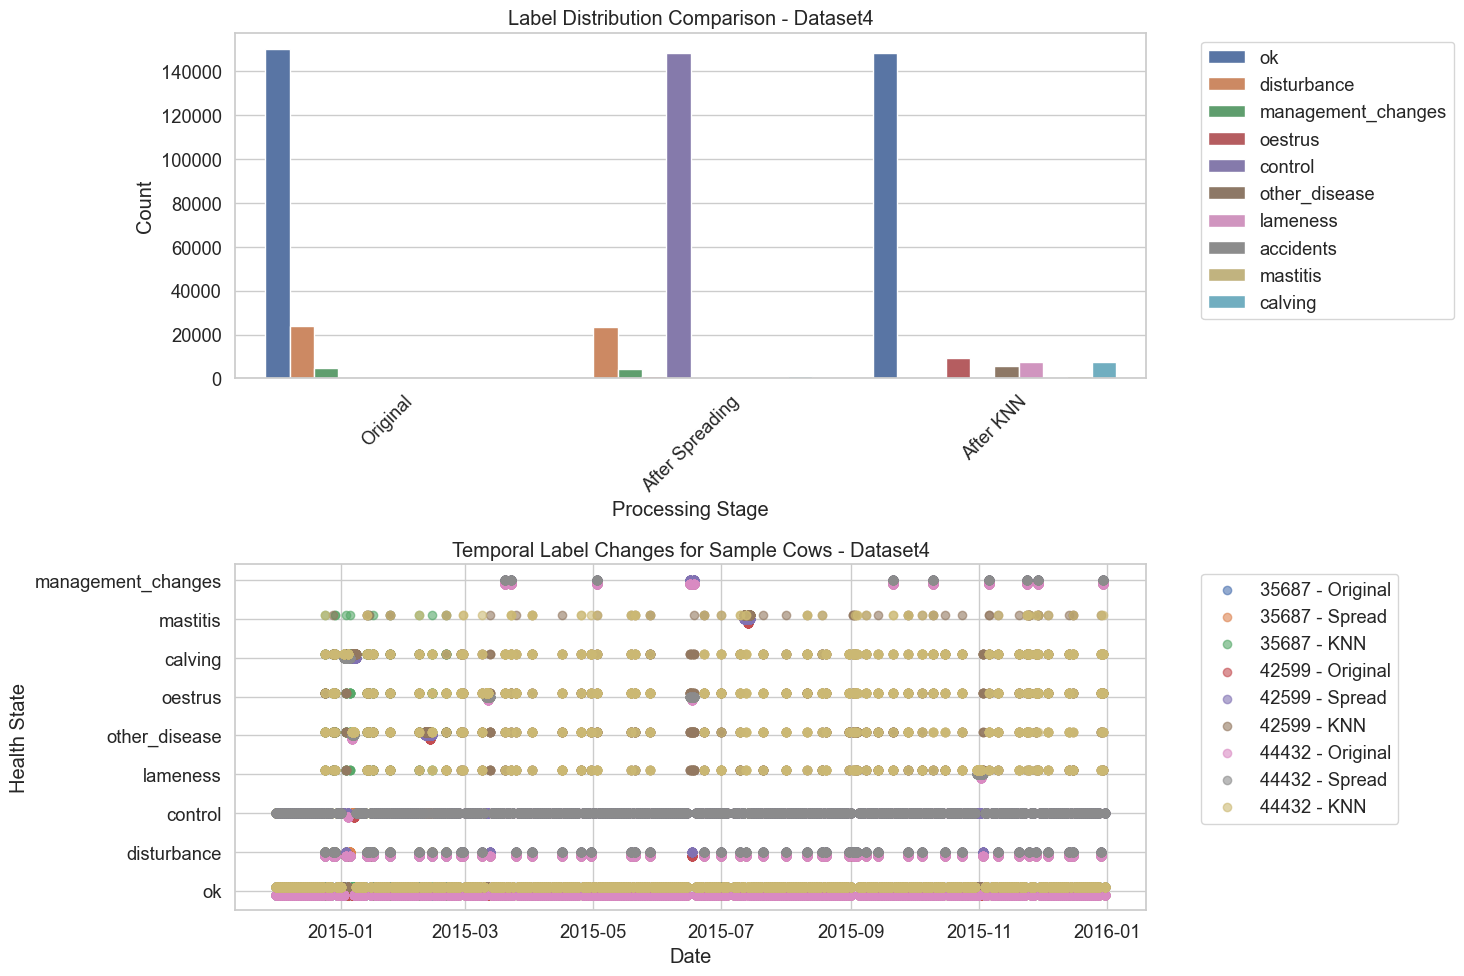

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [15]:
# Visualize the results
visualize_results(results)


Processing dataset: Dataset2

Analyzing health state durations:
Oestrus lasts between 1 and 2 days.
Lameness lasts 1 day.
Mastitis lasts 1 day.
Other_disease lasts 1 day.
No data available for "accidents".
Disturbance lasts between 1 and 4 days.
No data available for "mixing".
Management_changes lasts between 1 and 11 days.

Spreading labels to neighboring days:

Imputing missing labels with KNN:
  Physiological_Class  Number_of_Reassigned_Samples
0            lameness                         14227
1             oestrus                          2561
2            mastitis                           509
3       other_disease                           199
Saved KNN imputed version to: output\Dataset2_knn_imputed.csv

Completed processing Dataset2


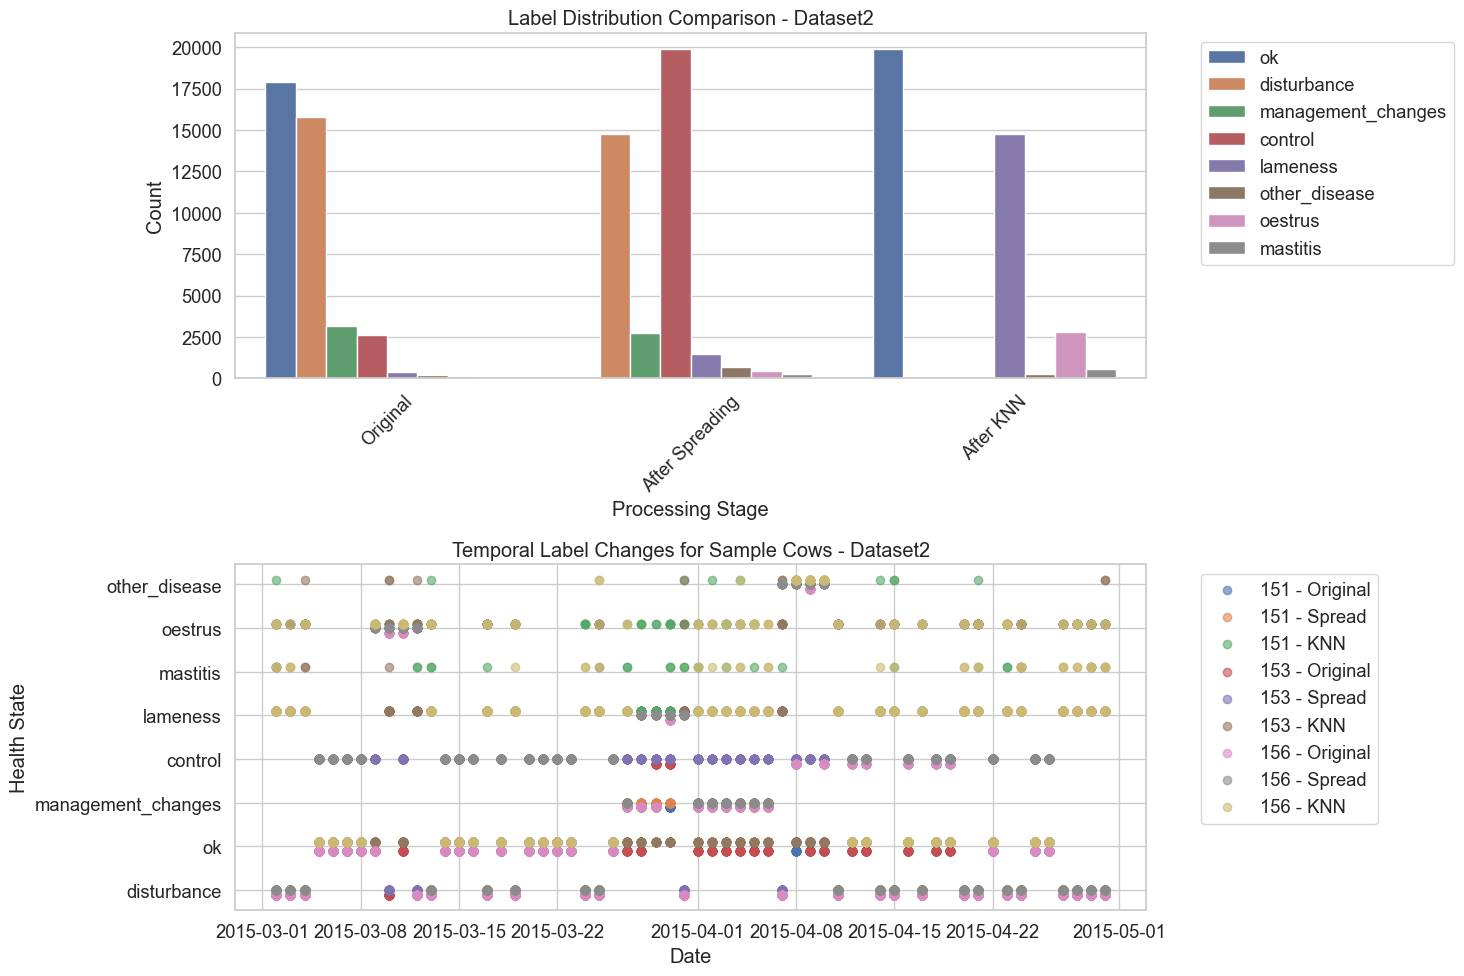

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [16]:
# Example usage with multiple datasets
datasets = {
    'Dataset2': r"C:/Users/lamia/Desktop/datasets/dataset2_physiological.csv",
    # 'Dataset2': 'path/to/dataset2.csv',
    # 'Dataset3': 'path/to/dataset3.csv',
    # 'Dataset4': 'path/to/dataset4.csv'
}

results = {}
for name, path in datasets.items():
    results[name] = process_dataset(path, name)
    print(f"\nCompleted processing {name}")
    print("="*50)
    visualize_results(results)